# Lending Club Data Analysis Project


QUESTION phase:
define problem
MODELING phase:
clean data
explore data
build model
VALIDATION phase:
validate model
CONCLUSION phase:
analysis result

read data, backup original as loanT, do not use Factors format for String

In [1]:
loan <- read.csv("loan.csv", stringsAsFactors = FALSE)
loanT <- loan

table like data(structured),do not need more data cleaning and feature engineering

In [2]:
head(loan, 5)

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,⋯,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1075358,1311748,3000,3000,3000,60 months,12.69,67.79,B,B5,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Question: predict int_rate(interest rate loan) (regression problem)
Examine relationship between each feature and response (int_rate), Pick 5 categorical and 5 numeric features, which you think are the most predictive with reasoning.


In [3]:
# int_rate is the response
response = loan$int_rate

In [4]:
# all others are features, where `which` find the index of column "int_rate"
features = loan[, -which(names(loan) == "int_rate")]

Whether numerical features are predictive can be quantified with correlation coefficient, for all the numberical deatures, calculate their correlation coefficient with int_rate

In [37]:

# clean emp_length feature data
## deinfe a function extract numbers from string
str2num <- function(str){
         as.numeric(gsub("([^0-9])", "", str))}
loan$emp_length = sapply(loan$emp_length, str2num)


In [38]:
library(corrr)
tbl_numerical=correlate(loan[, c('int_rate', 'emp_length','annual_inc','dti','inq_last_6mths','total_acc', 'tot_cur_bal', 
                                 'open_acc','acc_now_delinq','delinq_2yrs','collections_12_mths_ex_med','tot_coll_amt',
                                 'pub_rec','revol_bal','revol_util','total_rev_hi_lim','loan_amnt','installment','funded_amnt',
                           'funded_amnt_inv','last_pymnt_amnt','recoveries',
                           'total_pymnt','total_pymnt_inv','total_rec_int',
                           'total_rec_late_fee','total_rec_prncp','collection_recovery_fee',
                           'out_prncp','out_prncp_inv')],
                 use = "pairwise.complete.obs")[1,]
tbl_numerical


The downloaded binary packages are in
	/var/folders/fw/w49bbplj3z53v3byx9wr3mj00000gn/T//RtmpYwWXX1/downloaded_packages


rowname,int_rate,emp_length,annual_inc,dti,inq_last_6mths,total_acc,tot_cur_bal,open_acc,acc_now_delinq,⋯,last_pymnt_amnt,recoveries,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,collection_recovery_fee,out_prncp,out_prncp_inv
int_rate,NA,0.009029724,-0.07278563,0.07990255,0.2276505,-0.0386182,-0.0914078,-0.01038095,0.02647846,⋯,0.1011786,0.10684,0.1705063,0.1714793,0.4456788,0.05715012,0.05497527,0.07086706,0.04267137,0.04252901


In [39]:
tbl_numerical[[1]] <- NULL
tbl_numerical <- as.data.frame(tbl_numerical)
tbl_numerical[order(-abs(tbl_numerical))]

total_rec_int,revol_util,inq_last_6mths,total_pymnt_inv,total_pymnt,total_rev_hi_lim,funded_amnt_inv,funded_amnt,loan_amnt,installment,⋯,out_prncp,out_prncp_inv,total_acc,revol_bal,acc_now_delinq,collections_12_mths_ex_med,open_acc,emp_length,tot_coll_amt,int_rate
0.4456788,0.2691386,0.2276505,0.1714793,0.1705063,-0.1661193,0.1452053,0.1451603,0.1450231,0.1330749,⋯,0.04267137,0.04252901,-0.0386182,-0.03570809,0.02647846,0.01333591,-0.01038095,0.009029724,0.001129652,NA


Based on the correlation coefficient results above, we can find the most predictive 5 numerical features:

total_rec_int(Interest received to date): 0.4456788;
revol_util(Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit): 0.2691386;
inq_last_6mths(The number of inquiries in past 6 months (excluding auto and mortgage inquiries)): 0.2276505;
total_pymnt_inv(Payments received to date for portion of total amount funded by investors): 0.1714793;
total_pymnt(Payments received to date for total amount funded): 0.1705063.

3 of them are loan payment features, 1 of them is credit lines feature, and 1 of them is credit scores feature. 

data type
numerical
continous : e.g. int_rate
discrete : e.g. inq_fi(Number of personal finance inquiries),date?
categorical
ordinal : e.g. grade
nominal : e.g. zip code

[^0-9] : any character except digit 0-9

From https://www.lendingclub.com/foliofn/rateDetail.action
The final interest rate for each loan grade (and sub_grade) is the result of the following equation:
Lending Club Base Rate + Adjustment for Risk & Volatility
The Adjustment for Risk & Volatility is designed for each loan grade increment from A1 to G5.

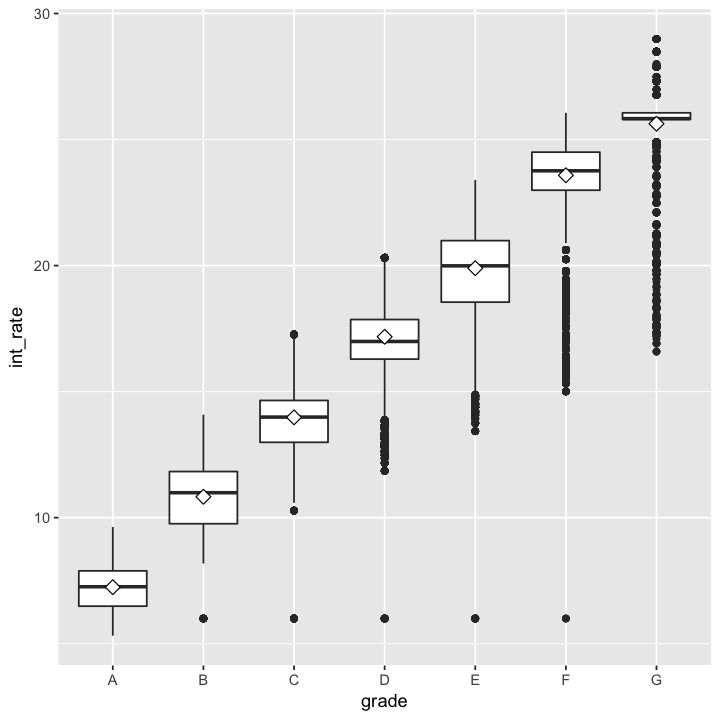

In [6]:
# load library
library(ggplot2)
options(repr.plot.width=6, repr.plot.height=6)
ggplot(loan, aes(x=factor(grade), y=int_rate)) + 
geom_boxplot() + labs(x='grade') + 
stat_summary(fun.y="mean", geom="point", shape=23, size=3, fill="white")

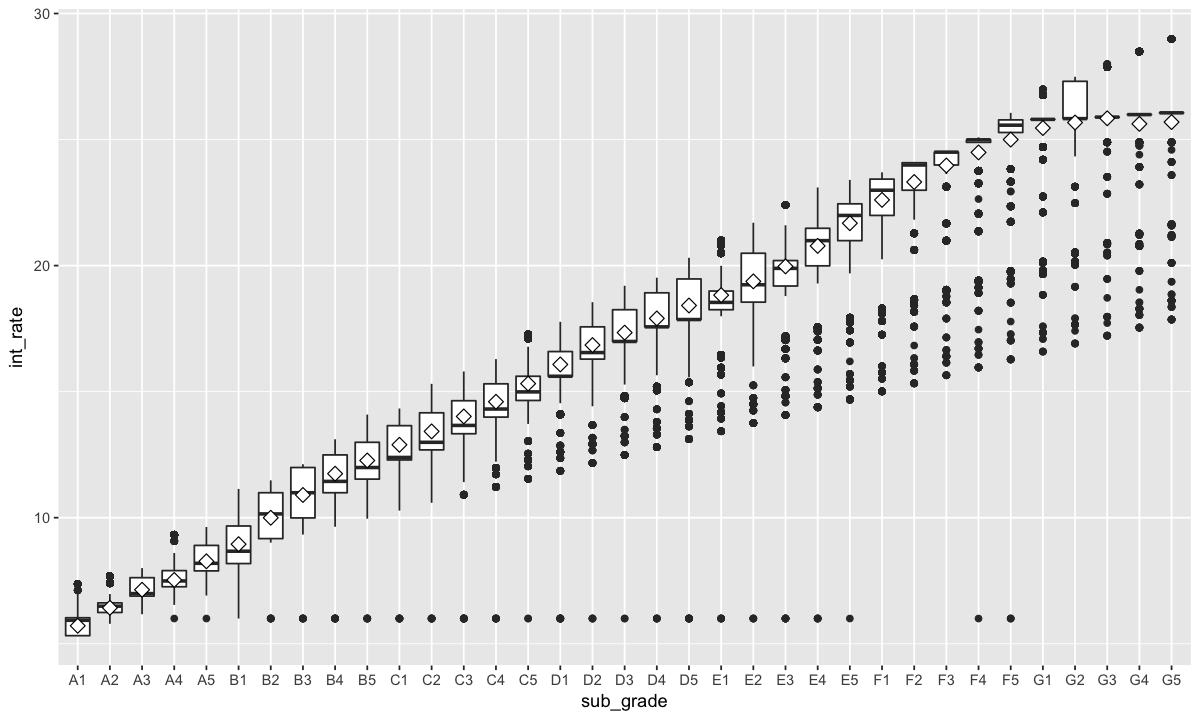

In [10]:
options(repr.plot.width=10, repr.plot.height=6)
ggplot(loan, aes(x=factor(sub_grade), y=int_rate)) + 
geom_boxplot() + labs(x='sub_grade') + 
stat_summary(fun.y="mean", geom="point", shape=23, size=3, fill="white")

Accoding to the boxplot (in_rate as a function of grade and sub_grade) above, we can learn that these two categorical features are the most predictive of int_rate

For the date related features, they can be splitted to year and month. Afterwards, we can combine year/month data together and convert them to continuous numerical features and quantify with correlate function.


In [41]:
library(zoo)
loan$earliest_cr_line_1 <- as.Date(as.yearmon(loan$earliest_cr_line, "%b-%Y"))
loan$earliest_cr_line_2 <- as.numeric(format(loan$earliest_cr_line_1, '%Y'))+as.numeric(format(loan$earliest_cr_line_1, '%m'))/12
loan$last_credit_pull_d_1 <- as.Date(as.yearmon(loan$last_credit_pull_d, "%b-%Y"))
loan$last_credit_pull_d_2 <- as.numeric(format(loan$last_credit_pull_d_1, '%Y'))+as.numeric(format(loan$last_credit_pull_d_1, '%m'))/12
loan$issue_d_1 <- as.Date(as.yearmon(loan$issue_d, "%b-%Y"))
loan$issue_d_2 <- as.numeric(format(loan$issue_d_1, '%Y'))+as.numeric(format(loan$issue_d_1, '%m'))/12
loan$last_pymnt_d_1 <- as.Date(as.yearmon(loan$last_pymnt_d, "%b-%Y"))
loan$last_pymnt_d_2 <- as.numeric(format(loan$last_pymnt_d_1, '%Y'))+as.numeric(format(loan$last_pymnt_d_1, '%m'))/12
loan$next_pymnt_d_1 <- as.Date(as.yearmon(loan$next_pymnt_d, "%b-%Y"))
loan$next_pymnt_d_2 <- as.numeric(format(loan$next_pymnt_d_1, '%Y'))+as.numeric(format(loan$next_pymnt_d_1, '%m'))/12
library(corrr)
tbl_date=correlate(loan[, c('int_rate', 'earliest_cr_line_2','last_credit_pull_d_2','issue_d_2',
                           'last_pymnt_d_2','next_pymnt_d_2')],
                 use = "pairwise.complete.obs")[1,]
tbl_date[[1]] <- NULL
tbl_date <- as.data.frame(tbl_date)
tbl_date[order(-abs(tbl_date))]


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



earliest_cr_line_2,issue_d_2,last_pymnt_d_2,next_pymnt_d_2,last_credit_pull_d_2,int_rate
0.104439,-0.07121371,-0.02699255,-0.01492683,-0.004416438,NA


Thus, earliest_cr_line (The month the borrower's earliest reported credit line was opened) and issue_d (The month which the loan was funded) have relatively large coefficient among them, but still very small.

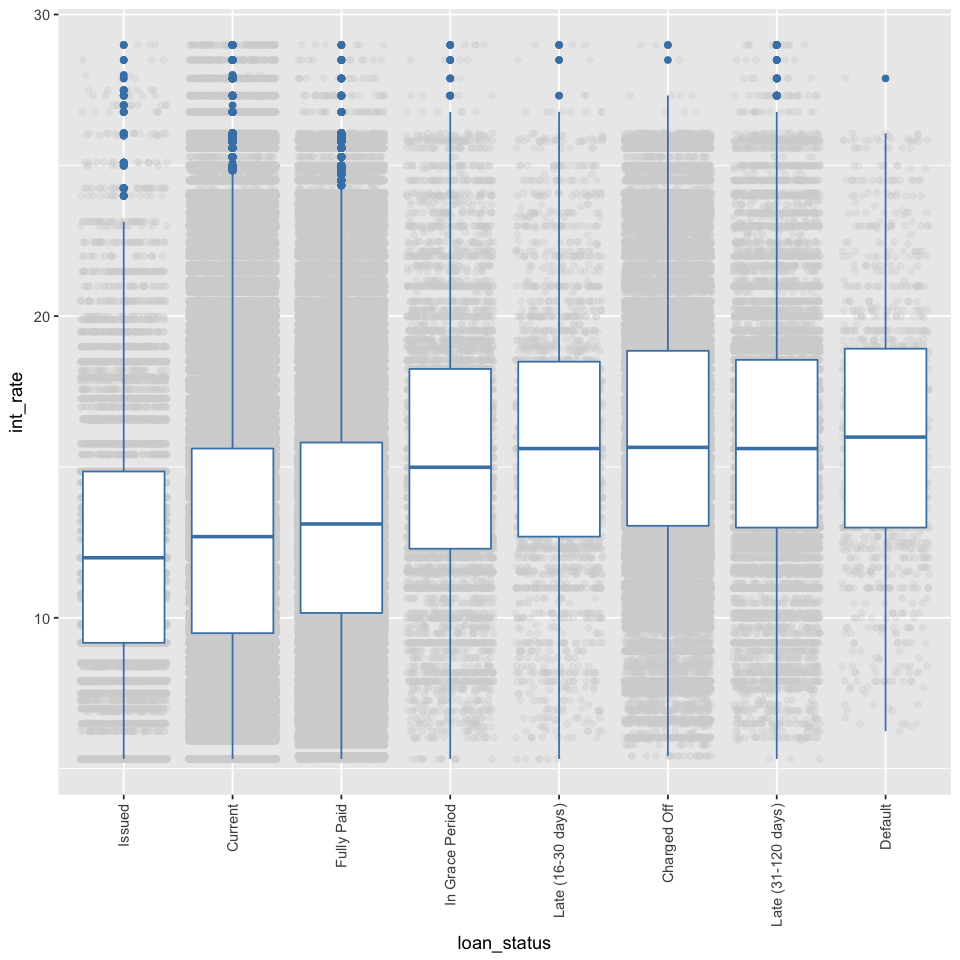

In [43]:
library(ggplot2)
# remove certain string from loan_status
loan$loan_status <- gsub('Does not meet the credit policy. Status:',
                         '', loan$loan_status)
options(repr.plot.width=8, repr.plot.height=8)
ggplot(loan, aes(x=factor(reorder(loan_status,int_rate)), y=int_rate)) + 
geom_jitter(alpha=0.3, color='lightgrey') +
geom_boxplot(color='steelblue') + 
labs(x='loan_status') + 
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=.5),
        legend.position = "none")

We see that "Current","Fully paid", "issued" have obviously lower interest rate than the other status

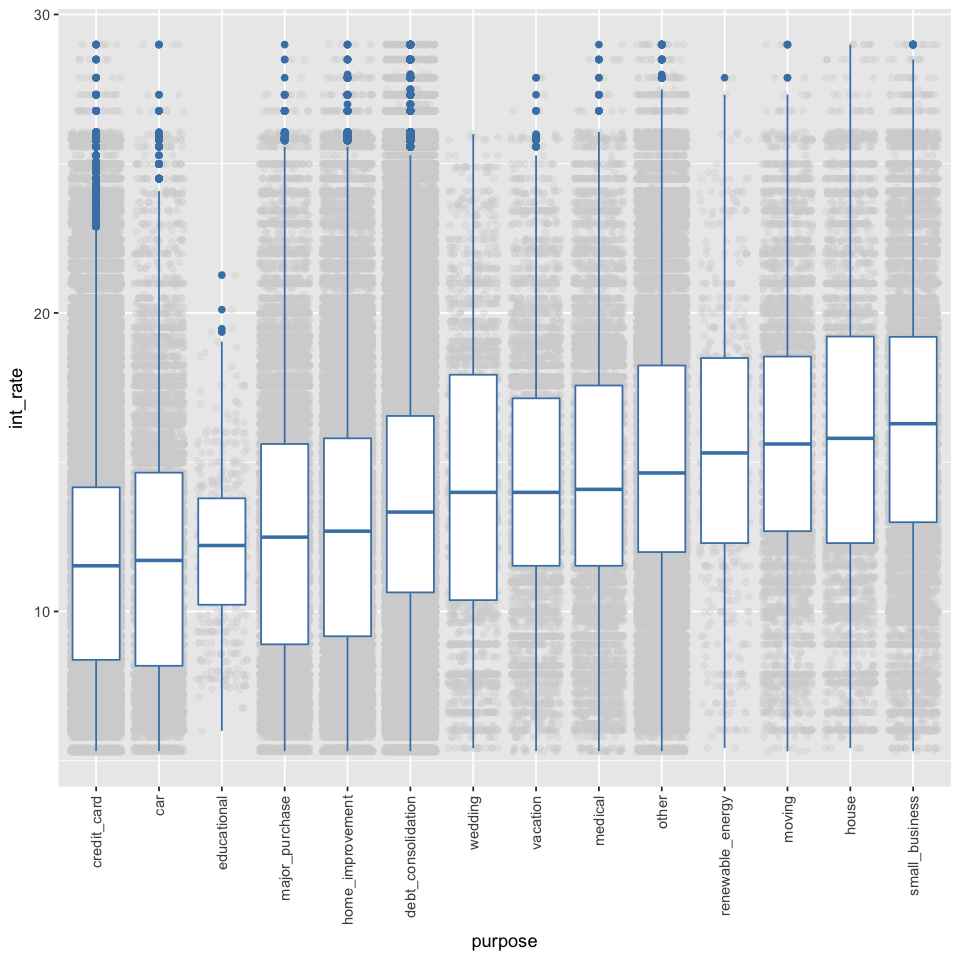

In [44]:
library(ggplot2)
options(repr.plot.width=8, repr.plot.height=8)
ggplot(loan, aes(x=factor(reorder(purpose,int_rate)), y=int_rate)) + 
geom_jitter(alpha=0.3, color='lightgrey') +
geom_boxplot(color='steelblue') + 
labs(x='purpose') + 
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=.5),
        legend.position = "none")

We can see that different purpose have distinct mean value, but since their distribution is large (other than educational)

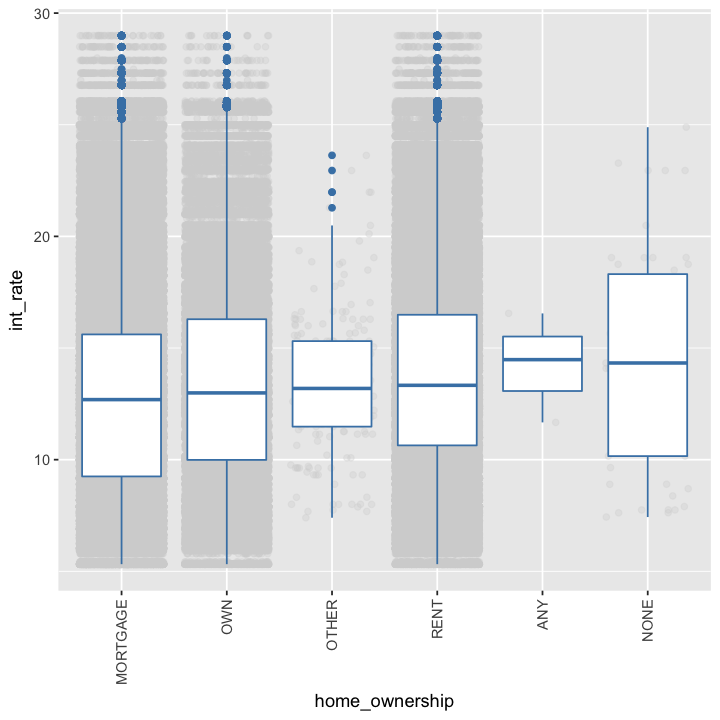

In [58]:
library(ggplot2)
options(repr.plot.width=6, repr.plot.height=6)
ggplot(loan, aes(x=factor(reorder(home_ownership,int_rate)), y=int_rate)) + 
geom_jitter(alpha=0.3, color='lightgrey') +
geom_boxplot(color='steelblue') + 
labs(x='home_ownership') + 
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=.5),
        legend.position = "none")

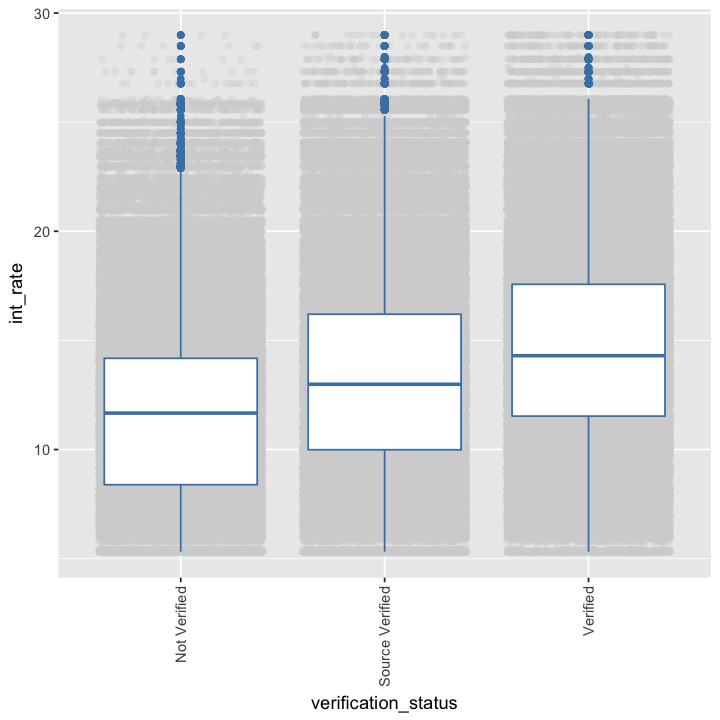

In [67]:
library(ggplot2)
options(repr.plot.width=6, repr.plot.height=6)
ggplot(loan, aes(x=factor(reorder(verification_status,int_rate)), y=int_rate)) + 
geom_jitter(alpha=0.3, color='lightgrey') +
geom_boxplot(color='steelblue') + 
labs(x='verification_status') + 
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=.5),
        legend.position = "none")

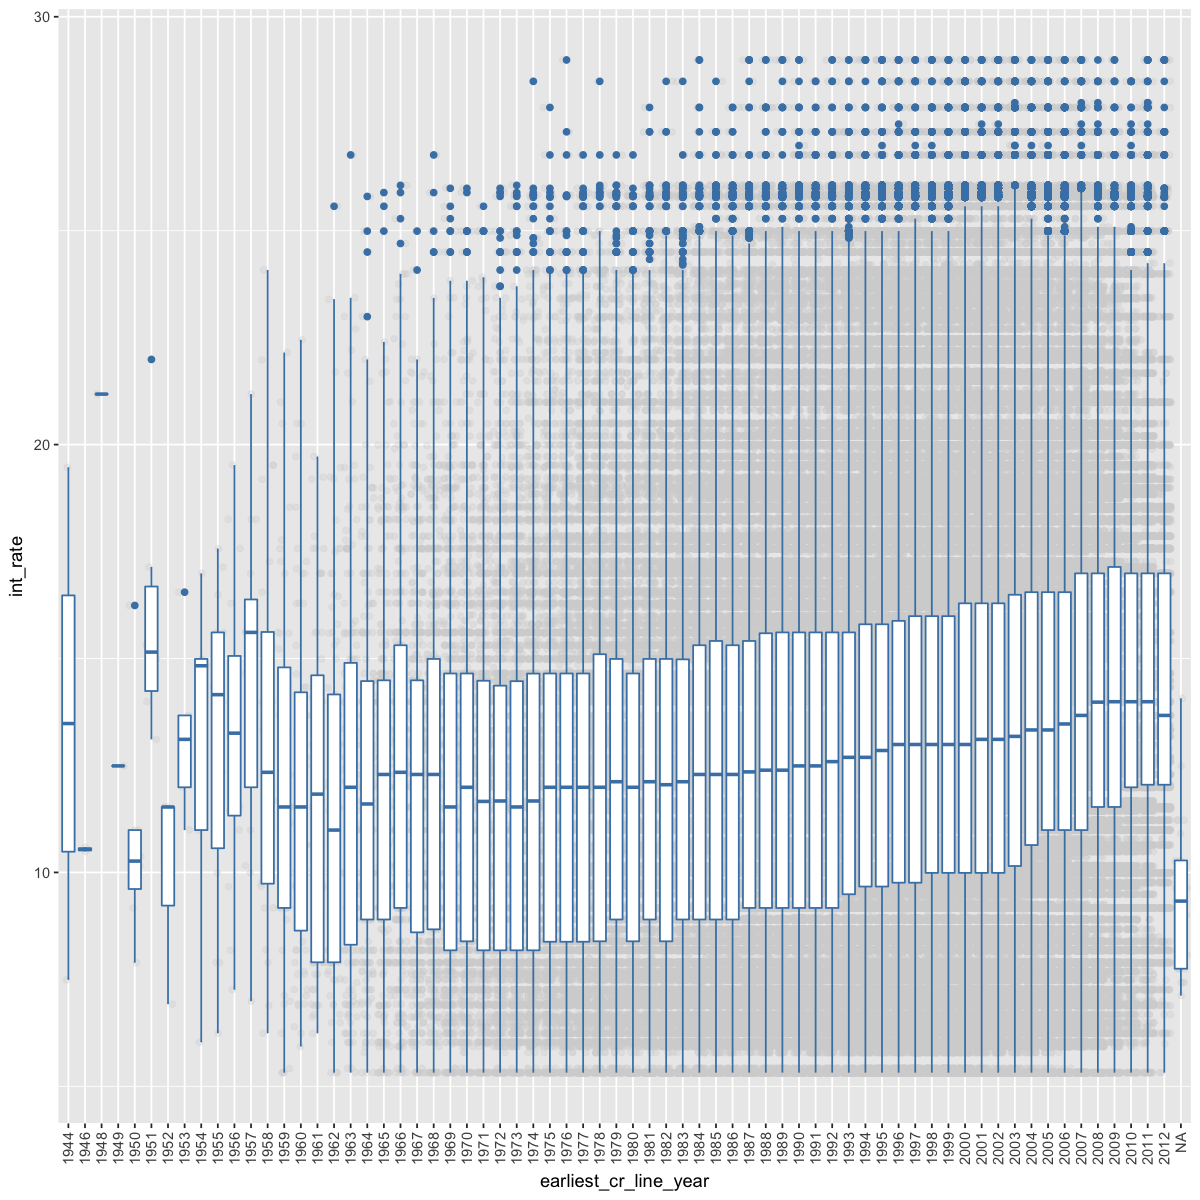

In [66]:
library(zoo)
loan$earliest_cr_line_1 <- as.Date(as.yearmon(loan$earliest_cr_line, "%b-%Y"))
loan$earliest_cr_line_year <- as.numeric(format(loan$earliest_cr_line_1, '%Y'))
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=10)
ggplot(loan, aes(x=factor(earliest_cr_line_year), y=int_rate)) + 
geom_jitter(alpha=0.3, color='lightgrey') +
geom_boxplot(color='steelblue') + 
labs(x='earliest_cr_line_year') + 
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=.5),
        legend.position = "none")+
scale_x_discrete()

Compare the best feature in all the data related features with other categorical features using the boxplots, we can see the earlist_cr_line might not be predictive: distribution is large and discrepency in all median values is small

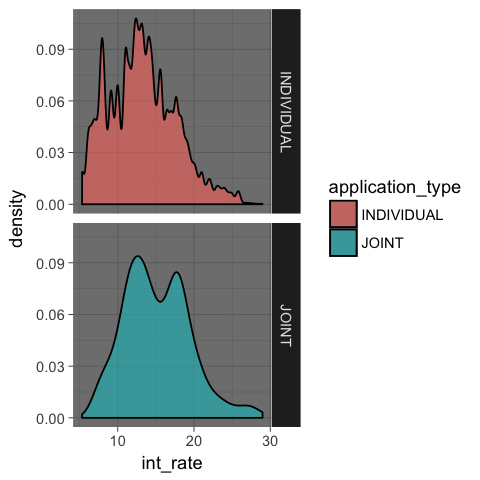

In [55]:
library(ggplot2)
options(repr.plot.width=4, repr.plot.height=4)
ggplot(loan, aes(x=int_rate, y= ..density.., fill=application_type)) + 
theme_dark() + 
facet_grid(application_type ~ .) +
geom_density(alpha= 0.6)

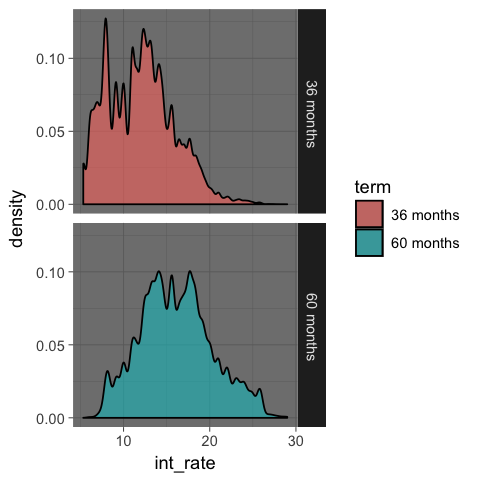

In [20]:
library(ggplot2)
options(repr.plot.width=4, repr.plot.height=4)
ggplot(loan, aes(x=int_rate, y= ..density.., fill=term)) + 
theme_dark() + 
facet_grid(term ~ .) +
geom_density(alpha= 0.6)

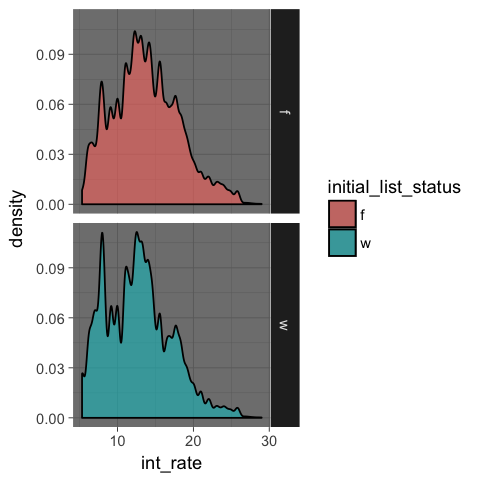

In [21]:
library(ggplot2)
options(repr.plot.width=4, repr.plot.height=4)
ggplot(loan, aes(x=int_rate, y= ..density.., fill=initial_list_status)) + 
theme_dark() + 
facet_grid(initial_list_status ~ .) +
geom_density(alpha= 0.6)

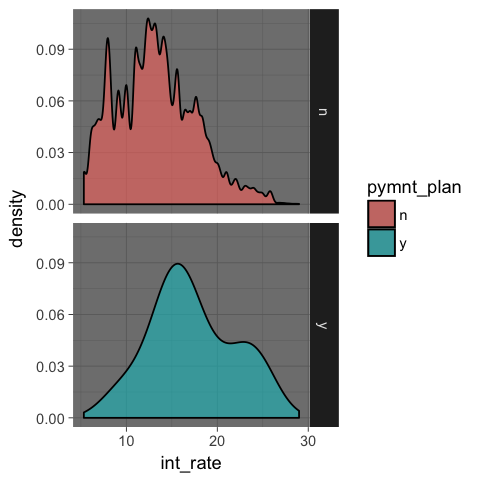

In [56]:
library(ggplot2)
options(repr.plot.width=4, repr.plot.height=4)
ggplot(loan, aes(x=int_rate, y= ..density.., fill=pymnt_plan)) + 
theme_dark() + 
facet_grid(pymnt_plan ~ .) +
geom_density(alpha= 0.6)

For all the binary categorical features: 'application_tyoe', 'term','initial_list_status' and 'pymnt_plan', I used density plot to show their coorelations with ins_rate: 'term' and 'pymnt_plan' may be the most predictive among them.

Then I use the table plot to compare those "candidate" categorical features in one figure. For application_type, verification_status_joint and pymnt_plan, they might be predictive, but they are binary features and one of the values is dominant, which makes this feature less usful. In this sense, I will choose purpose as a predictive feature. 
As for the features: "addr_states" have too many variables, may be discussed in the future; "emp_title","desc",
"member_id", "zip_code", "url","id","title" have too many variables, and may be useless; "policy_code" only has one unique variable useless. 

In [ ]:
library(tabplot)
tableplot(loan, select = c('int_rate', 'home_ownership','verification_status','verification_status_joint','application_type',
                           'purpose', 'term','initial_list_status', 'pymnt_plan','loan_status'))

<img src="./Rtableplot.png">

Summarize the analyze above, we can see that the most predictive 5 categorical features are: sub_grade (LC assigned loan subgrade), grade(LC assigned loan grade), loan_status(Current status of the loan), term (The number of payments on the loan. Values are in months and can be either 36 or 60) and purpose(A category provided by the borrower for the loan request)
3 of them are pontential responsive variables, 
two of them are from loan general features. 

Question: How to generate potential useful features from existing data?


1. From categorical to numerical: for all the date features, can be convert to numerical features, as I did above;
2. From emp_length feature, we did a little bit data cleaning to transfer categorical to numeric;
3. From feature like some of the data information and loan_status, we might simplify or decrease the number of variables to make a better conclusion;
4. For the feature like desc, we need nlp method in the future to get useful information from it; 
5. For those features with obvious linear correlations with numeric features, we might transfer categorical features like grade/subgrade into numerical features. 

In [68]:
# sub_grade_int_ave: use int_rate average in sub_grade group to generate a feature call sub_grade_int_ave
sub_grade = by(loan$int_rate, loan$sub_grade, mean)
loan$sub_grade_int_ave = sapply(loan$sub_grade, function(x){sub_grade[x]})
head(loan$sub_grade_int_ave)
head(loan$sub_grade)


[1]  9.996643 14.598235 15.318153 12.892132 12.269169  7.529181

[1] "B2" "C4" "C5" "C1" "B5" "A4"

Question: What other questions you can explore using this data set? 


Question1: missing value exploration:
we observe some pattern in the missing map, what's the reason of this missing?

In [15]:
# missing map
install.packages("Amelia")
library("Amelia")
png("missmap.png", height = 30000, width = 2048)
missmap(loanT)
dev.off()

also installing the dependency ‘RcppArmadillo’




The downloaded binary packages are in
	/var/folders/fw/w49bbplj3z53v3byx9wr3mj00000gn/T//RtmpP7bV3q/downloaded_packages


Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2017 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 


pdf 
  2

<img src="./missmap.png">

we can see that some of the missing data (in the middle) seem to be not random, we might in the future further discuss if this is technical issue or some other reason of those missing data. Thus, we might be able to implement those missing data, or in the future, delete some of the useless and missing features.

In [ ]:
Question 2: addr_state and ins_rate relationship
#sudo apt-get install libudunits2-dev
#install.packages(libudunits2-dev)  
install.packages("choroplethr")
install.packages("choroplethrMaps") 
library(choroplethr)
library(choroplethrMaps)
state.ave.int_rate = as.list(by(loan$int_rate, loan$addr_state, mean))
state.names = names(state.ave.int_rate)
names(state.ave.int_rate) = NULL
state.int_rate.df = data.frame(region = state.names, value = unlist(state.ave.int_rate))
full.name = c()
for(i in 1:51)
{
    if(i==8){
        full.name <- append(full.name, "district of columbia")
    }else{
        full.name <- append(full.name, tolower(state.name[state.int_rate.df[i,1] == state.abb]))
    }
}
state.int_rate.df$region = full.name
options(repr.plot.width=16, repr.plot.height=8)
state_choropleth(state.int_rate.df)

<img src="./Rplotstates.png">

There is not a very obvious trend in the state map, we might also need to compare with other information like state average income, GDP, and economics data to make a conclusion.

Question 3: As an investor, we might be also intersted in loan_status, thus, if we take "loan_status" as response, all others are features. But since loan_status is categorical, it might be difficult to find a relationship with it. 

Question 4: we can learn and plot what is the reason that people use lending club. If we group all the lending data into different purpose, we may find relationship between purpose, and int_rate, loan_status, grade and etc. 


       educational   renewable_energy            wedding              house 
               423                575               2347               3707 
          vacation             moving            medical                car 
              4736               5414               8540               8863 
    small_business     major_purchase              other   home_improvement 
             10377              17277              42894              51829 
       credit_card debt_consolidation 
            206182             524215 


       educational   renewable_energy            wedding              house 
              0.00               0.00               0.00               0.00 
          vacation             moving            medical                car 
              0.01               0.01               0.01               0.01 
    small_business     major_purchase              other   home_improvement 
              0.01               0.02               0.05               0.06 
       credit_card debt_consolidation 
              0.23               0.59 

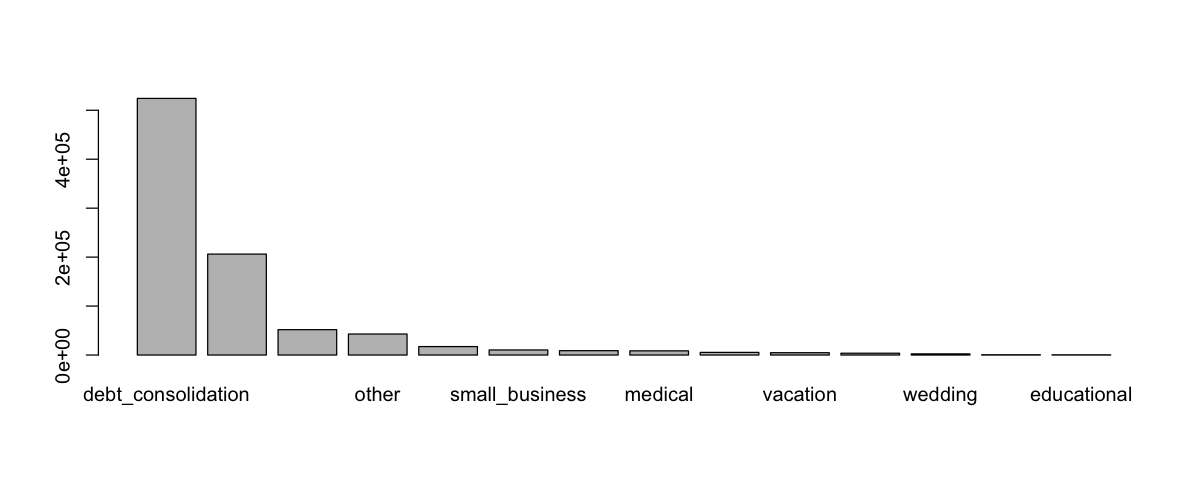

In [26]:
options(repr.plot.width=10, repr.plot.height=4)
sort(table(loan$purpose))
round(sort(table(loan$purpose)) / dim(loan)[1], 2)
barplot(sort(table(loan$purpose), decreasing = TRUE))

In [2]:
aov.res = aov(int_rate ~ factor(verification_status), na.action = na.omit, data = loan, )
summary(aov.res)

                                Df   Sum Sq Mean Sq F value Pr(>F)    
factor(verification_status)      2  1080177  540089   30032 <2e-16 ***
Residuals                   887376 15958157      18                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1